### 数据初步可视化

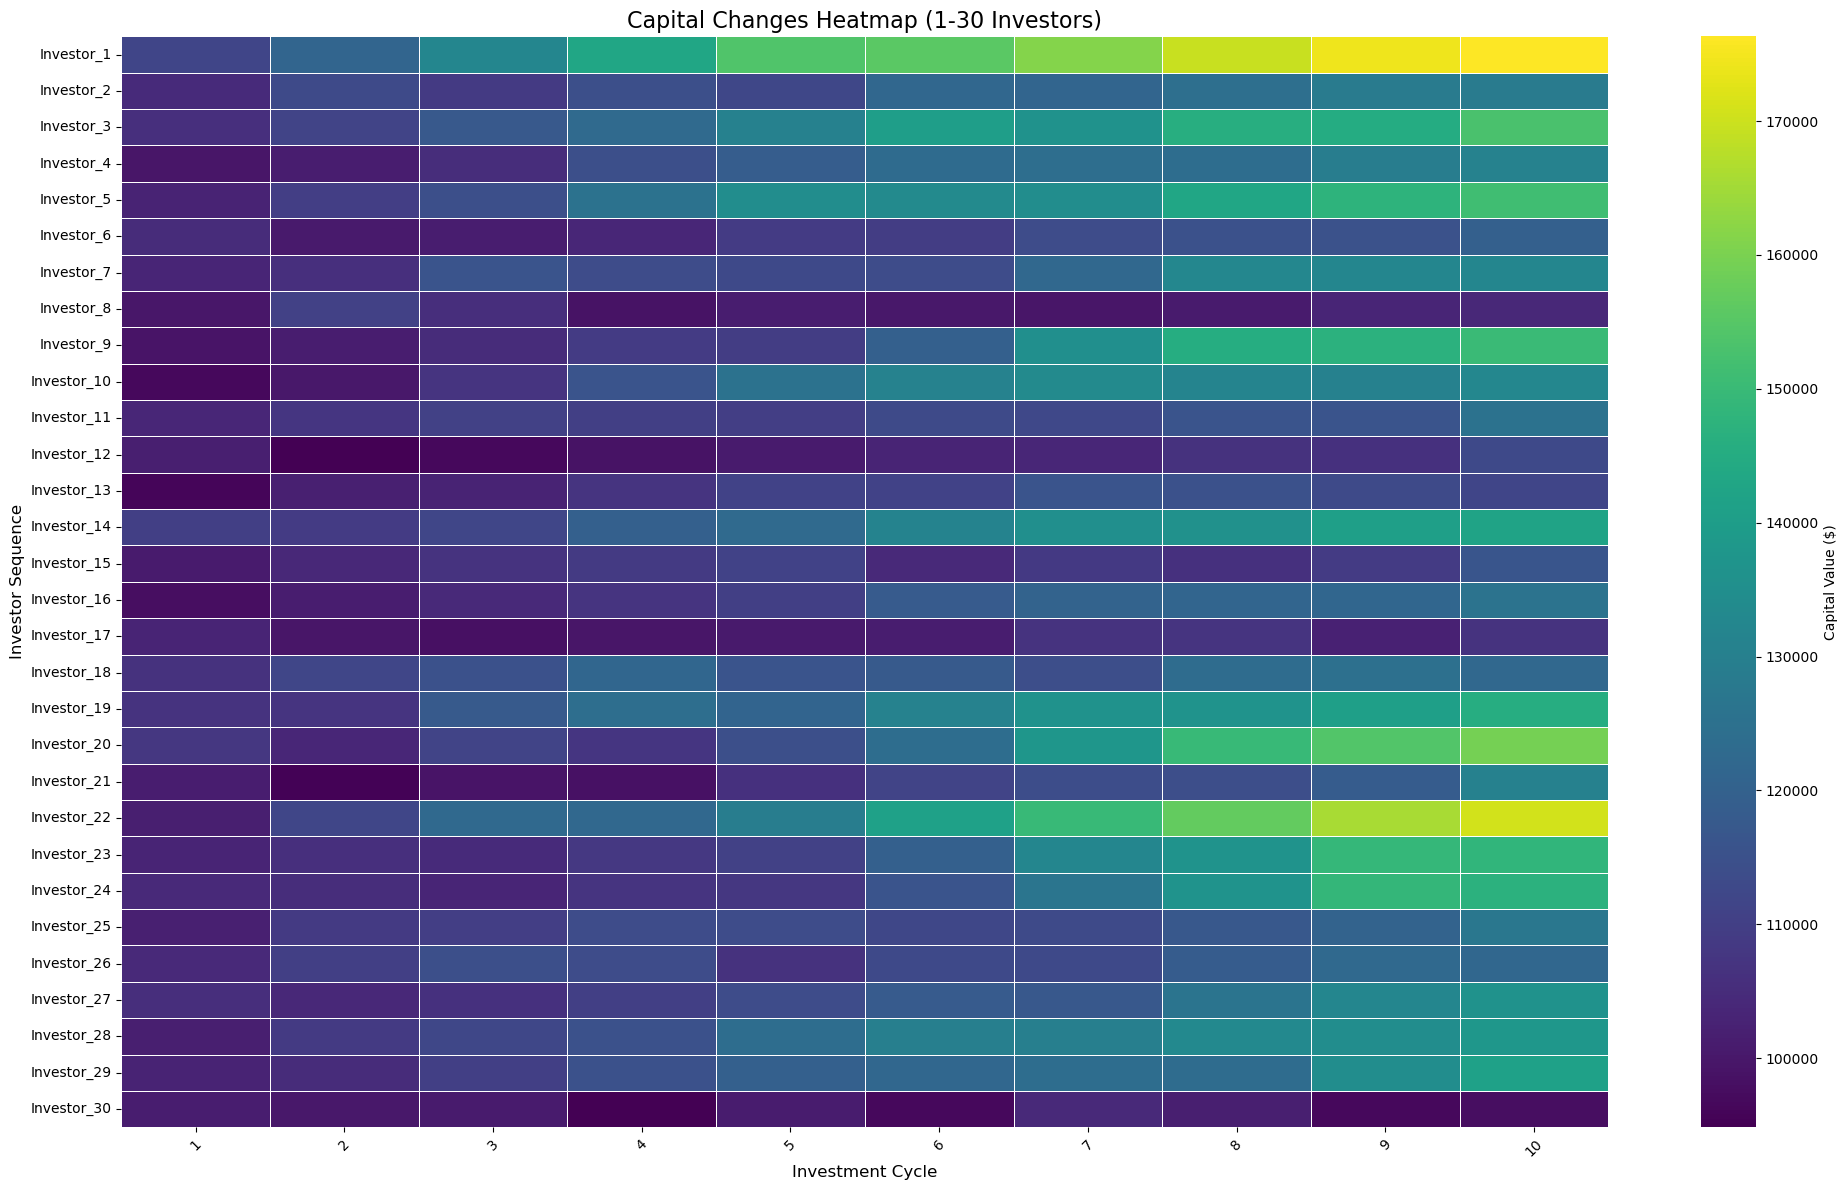

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# 读取CSV文件（请替换为你的实际文件路径）
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')

# 数据预处理：保留每个投资者每个投资周期的最终期末资本
# 假设每个Investment_No的最后一条记录的Period_End_Capital是最终值
final_capitals = df.groupby(['Investor_ID', 'Investment_No']).last()['Period_End_Capital'].reset_index()


# 数据重塑为三维结构（投资者×周期×资本）
heatmap_data = df.pivot_table(index='Investor_ID', 
                             columns='Investment_No', 
                             values='Period_End_Capital')

# 排序处理（确保与图片顺序一致）
heatmap_data = heatmap_data.reindex([f'Investor_{i}' for i in range(1,31)])

plt.figure(figsize=(20, 12))
sns.heatmap(heatmap_data, 
           cmap='viridis',
           annot=False, 
           linewidths=0.5,
           cbar_kws={'label': 'Capital Value ($)'})
plt.title('Capital Changes Heatmap (1-30 Investors)', fontsize=16)
plt.xlabel('Investment Cycle', fontsize=12)
plt.ylabel('Investor Sequence', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
# plt.savefig('/Users/hanyanlong/Desktop/four_paper/Heatmap-Data Visualization.pdf', format='pdf')
plt.show()

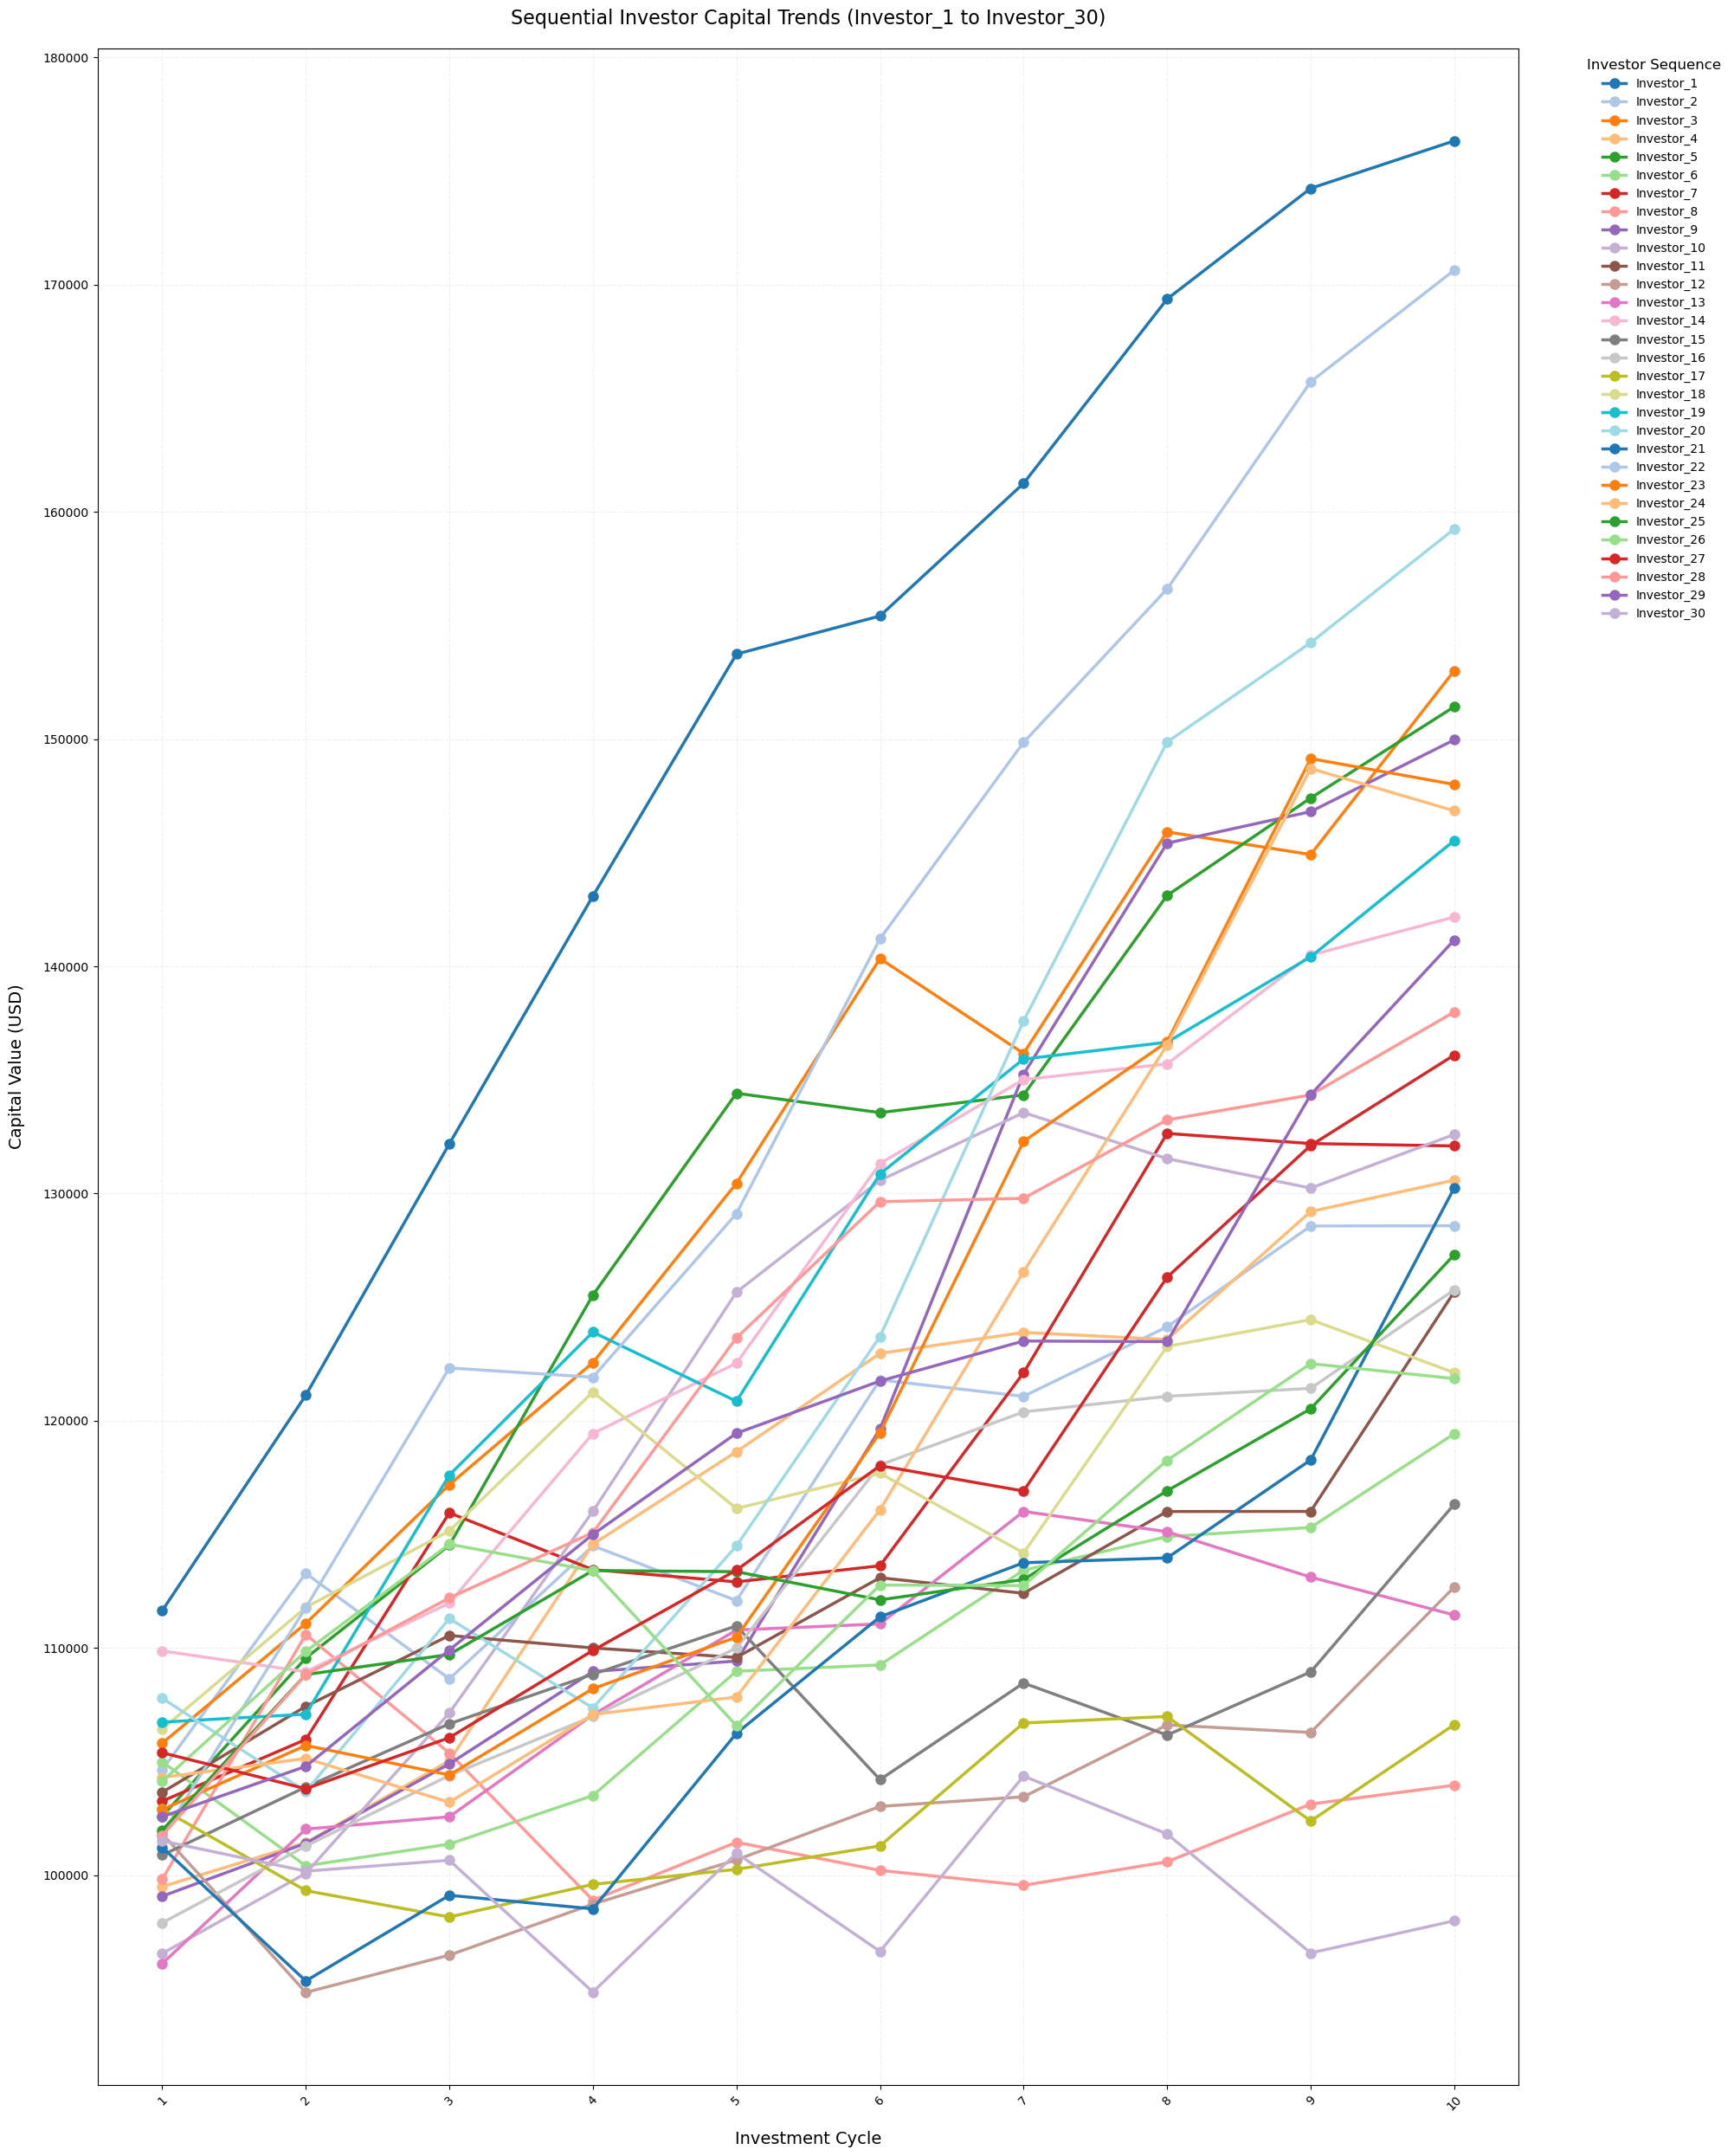

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

# 读取数据
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')

# 生成规范的投资人排序列表（根据图片显示的完整序列）
correct_order = [f'Investor_{i}' for i in range(1,31)]

# 数据处理时强制排序
final_capitals = (
    df.groupby(['Investor_ID', 'Investment_No'])
    .last()['Period_End_Capital']
    .reset_index()
    # 添加排序辅助列
    .assign(sort_key=lambda x: x['Investor_ID'].str.extract('(\d+)').astype(int))
    .sort_values(['sort_key', 'Investment_No'])
)

# 创建透视表时指定列顺序
pivot_df = final_capitals.pivot(
    index='Investment_No',
    columns='Investor_ID',
    values='Period_End_Capital'
).reindex(columns=correct_order)  # 关键排序控制

# 可视化设置
plt.figure(figsize=(20, 25))
color_palette = plt.cm.tab20.colors * 2  # 扩展颜色序列匹配30个投资者

# 按规范顺序绘制折线
for idx, investor in enumerate(pivot_df.columns):
    plt.plot(pivot_df.index,
             pivot_df[investor],
             color=color_palette[idx],
             marker='o',
             linewidth=2.5,
             markersize=8,
             label=investor)

# 增强可视化效果
plt.title('Sequential Investor Capital Trends (Investor_1 to Investor_30)', 
         fontsize=16, pad=20)
plt.xlabel('Investment Cycle', fontsize=14, labelpad=15)
plt.ylabel('Capital Value (USD)', fontsize=14, labelpad=15)
plt.grid(True, alpha=0.2, linestyle='--')
plt.legend(title='Investor Sequence', 
          bbox_to_anchor=(1.15, 1), 
          title_fontsize=12,
          fontsize=10,
          frameon=False)

# 优化坐标轴
plt.xticks(pivot_df.index, rotation=45)
plt.tight_layout()
plt.show()

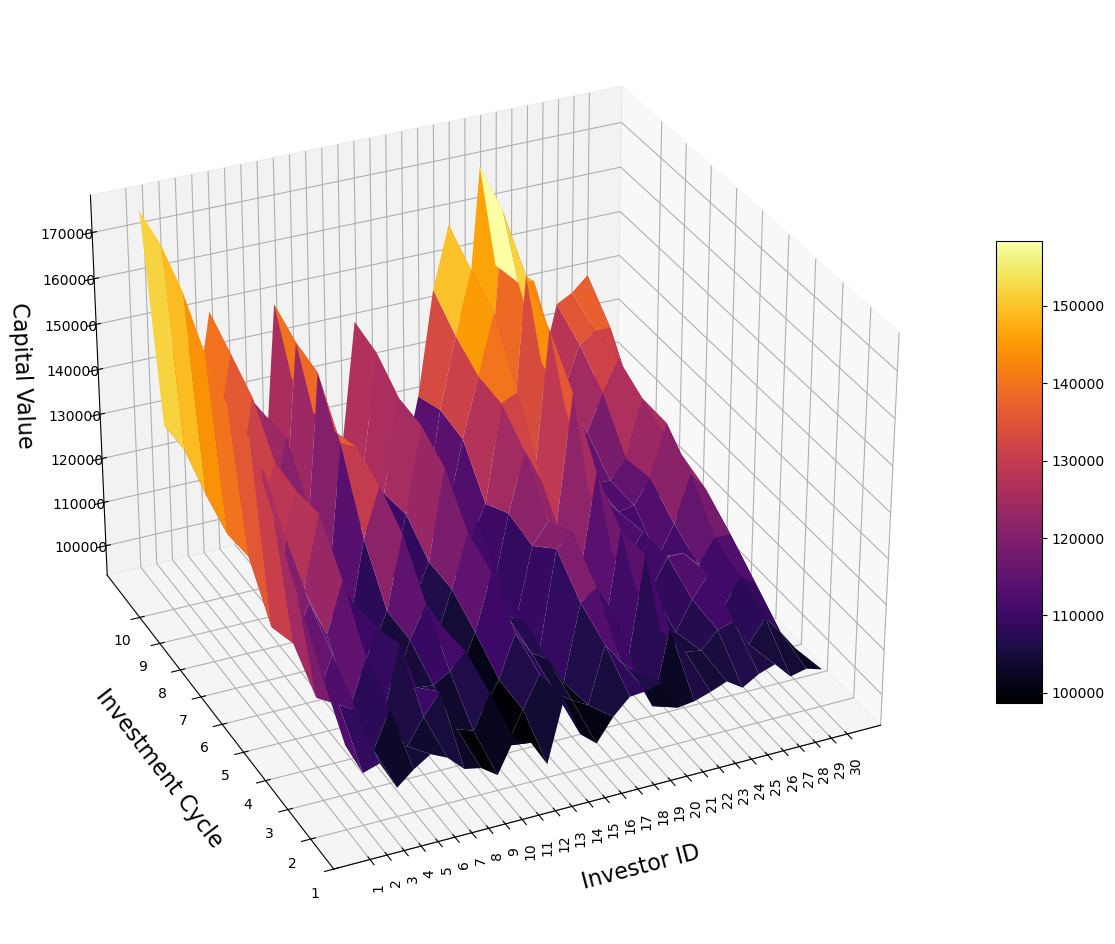

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# 读取数据
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111, projection='3d')

# 生成网格坐标
investors = [f'Investor_{i}' for i in range(1,31)]
x = np.arange(len(investors))  # 投资者编号
y = df['Investment_No'].unique()  # 投资周期
X, Y = np.meshgrid(x, y)
Z = heatmap_data.T.values  # 资本值矩阵

surf = ax.plot_surface(X, Y, Z, cmap='inferno', edgecolor='none')
ax.set_zlabel('Capital Value', labelpad=15,fontsize=16)
ax.set_xlabel('Investor ID', labelpad=15,fontsize=16)
ax.set_ylabel('Investment Cycle', labelpad=15,fontsize=16)
ax.set_xticks(np.arange(len(investors)))
ax.set_xticklabels(x+1, rotation=90)
ax.set_yticks(np.arange(len(y)))
ax.set_yticklabels(y)
ax.grid(True)
ax.view_init(30, 245)  # 调整观察角度

fig.colorbar(surf, shrink=0.5, aspect=10)
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/Investor-3D.pdf', format='pdf')
plt.show()

### 开始处理数据

Step 1. 计算股票的评价指标

In [5]:
import pandas as pd

# 1. 读取原始数据
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')

# 2. 计算每个周期的收益率 R_{i,t}
df['period_return'] = (
    df['Period_End_Capital'] - df['Period_Start_Capital']
) / df['Period_Start_Capital']

# 3. 按投资者计算平均收益率和收益波动率
stats = (df.groupby('Investor_ID')['period_return'].agg(['mean', 'std']).reset_index().rename(columns={
          'mean': 'mean_return',
          'std': 'return_volatility'
      })
)

# 4. 定义评价指标参数
alpha = 1.0      # 收益权重
beta = 1.0       # 波动惩罚权重
epsilon = 1e-6   # 防止除零

# 5. 计算线性组合型历史表现指数 PI_i
stats['performance_index'] = (alpha * stats['mean_return'] - beta * stats['return_volatility']
)

# 6. 计算比率型历史表现得分 PS_i
stats['performance_score'] = (stats['mean_return'] / (stats['return_volatility'] + epsilon)
)

# # 7. 将结果保存为新的 CSV 文件
# output_path = '/Users/hanyanlong/Desktop/four_paper/investor_pingjia.csv'
# stats.to_csv(output_path, index=False)

# print(f"已将结果保存至：{output_path}")

全局投资判别效能：如果仅仅依靠历史的收益来判断一个投资人的眼光是不合理的，理由是如果一个投资人非常激进，刚好他的运气也特别好，在某个时期大赚一笔，而在其他时期的投资选择都是错误的，这不能说明他是一个精明的投资者。所以必须分析其历史投资的判断能力。

In [6]:
import pandas as pd

# 读取数据（假设数据已加载为DataFrame）
# 如果从文件读取，使用: df = pd.read_csv("investor_data.csv")
data = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')

columns = [
    "Investor_ID", "Investment_No", "Start_Date", "End_Date", "Stock_Ticker",
    "Weight (%)", "Buy_Price", "Sell_Price", "Period_Start_Capital",
    "Allocated_Capital", "Shares", "Invested_Amount", "Sell_Proceeds", "Profit",
    "Cash_Leftover", "Period_End_Capital"
]

df = pd.DataFrame(data, columns=columns)

# 计算每个周期每个投资人的准确率
def period_accuracy(group):
    success = (group["Sell_Price"] > group["Buy_Price"]).sum()
    total = len(group)
    return f"{success}/{total} ({success/total:.2%})"

period_result = df.groupby(["Investor_ID", "Investment_No"]).apply(period_accuracy).reset_index()
period_result.columns = ["Investor_ID", "Investment_No", "Cycle Investment Discrimination Efficiency"]

# 计算每个投资人的总体准确率
def investor_accuracy(group):
    success = (group["Sell_Price"] > group["Buy_Price"]).sum()
    total = len(group)
    return f"{success/total}"

investor_result = df.groupby("Investor_ID").apply(investor_accuracy).reset_index()
investor_result.columns = ["Investor_ID", "Global Investment Discrimination Efficiency"]

# # 打印结果
# print("每个投资人的周期准确率:")
# print(period_result.to_string(index=False))

# investor_result.to_csv('/Users/hanyanlong/Desktop/four_paper/investor_accuracy.csv', index=False)
# print("已输出每个投资人的全局投资判别效能到 investor_accuracy.csv")

print("\n每个投资人的全局投资判别效能:")
print(investor_result.to_string(index=False))


每个投资人的全局投资判别效能:
Investor_ID Global Investment Discrimination Efficiency
 Investor_1                                        0.78
Investor_10                                        0.58
Investor_11                                         0.7
Investor_12                                        0.56
Investor_13                                        0.58
Investor_14                                        0.74
Investor_15                                        0.66
Investor_16                                        0.72
Investor_17                                        0.68
Investor_18                                        0.58
Investor_19                                        0.68
 Investor_2                                         0.7
Investor_20                                         0.7
Investor_21                                        0.66
Investor_22                                        0.82
Investor_23                                        0.66
Investor_24                    

/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_74125/2110465393.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  period_result = df.groupby(["Investor_ID", "Investment_No"]).apply(period_accuracy).reset_index()
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_74125/2110465393.py:31: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  investor_result = df.groupby("Investor_ID").apply(inve

Step 2.使用信息准则AIC来确定最优的专家数量K

✅ 最优专家数量 K = 13
✅ 最小IC = -12.3556
     K         IC  log_return_sum
0    1  -2.343730        2.671865
1    2  -5.015732        5.507866
2    3  -5.462747        7.231374
3    4  -6.611887        9.305943
4    5  -6.831912       10.915956
5    6  -7.350386       12.675193
6    7  -7.432113       14.216057
7    8  -8.685314       16.342657
8    9  -9.437738       18.218869
9   10  -8.729484       19.364742
10  11  -9.650240       21.325120
11  12 -11.303142       23.651571
12  13 -12.355633       25.677817
13  14 -11.769906       26.884953
14  15 -11.438694       28.219347
15  16 -12.280757       30.140379
16  17 -11.565354       31.282677
17  18 -11.348788       32.674394
18  19 -10.862573       33.931287
19  20 -10.684171       35.342086
20  21 -10.326709       36.663355
21  22  -9.101847       37.550924
22  23  -8.078249       38.539125
23  24  -6.590194       39.295097
24  25  -5.588048       40.294024
25  26  -3.781492       40.890746
26  27  -1.865347       41.432673
27  28   0.493

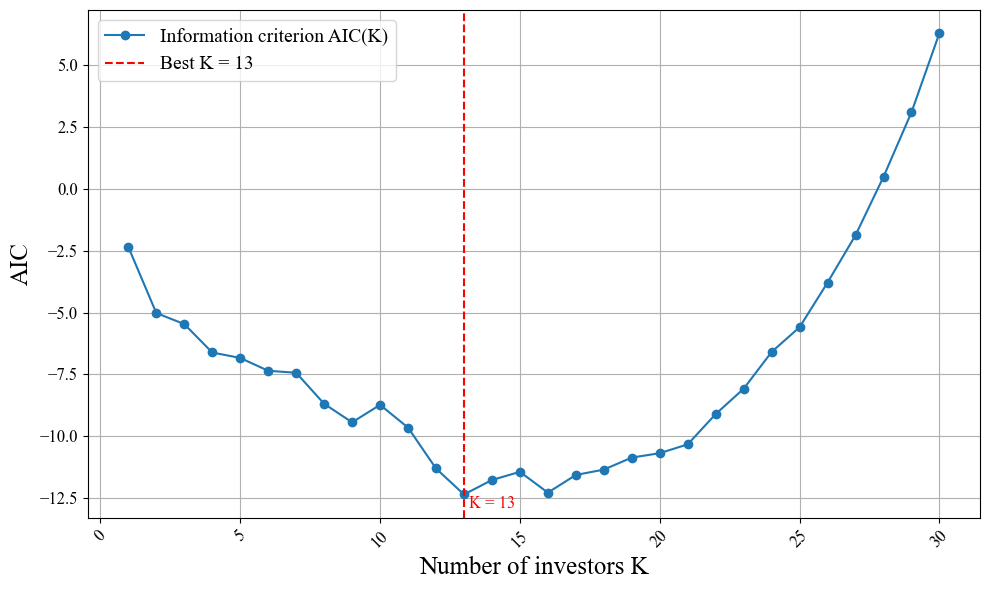

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体为 Times New Roman
rcParams['font.family'] = 'Times New Roman'

# 读取数据
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')
stats = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_pingjia.csv')

# 计算每笔投资的收益率
df['period_return'] = (df['Period_End_Capital'] - df['Period_Start_Capital']) / df['Period_Start_Capital']

# 合并专家得分
df = df.merge(stats[['Investor_ID', 'performance_score']], on='Investor_ID', how='left')

# 参数
lambda_ = 3  # 惩罚参数
max_K = 30
results = []

# 分析每个 K 值
for K in range(1, max_K + 1):
# for K in range(16, 17):
    top_experts = stats.nlargest(K, 'Overall Investment Scoreee')['Investor_ID'].tolist()
    top_returns = df[df['Investor_ID'].isin(top_experts)]['period_return']
    # print(top_returns)
    log_returns = np.log(1 + top_returns.dropna())
    log_return_sum = log_returns.sum()
    ic = -2 * log_return_sum + lambda_ * K

    results.append({'K': K, 'IC': ic, 'log_return_sum': log_return_sum})

# 结果表 & 最优 K
result_df = pd.DataFrame(results)
best_K = result_df.loc[result_df['IC'].idxmin()]
K_best = int(best_K['K'])
print("✅ 最优专家数量 K =", int(best_K['K']))
print("✅ 最小IC =", round(best_K['IC'], 4))
print(result_df)

# 可视化
plt.figure(figsize=(10, 6))
plt.plot(result_df['K'], result_df['IC'], marker='o', label='Information criterion AIC(K)')
plt.axvline(x=best_K['K'], color='red', linestyle='--', label=f'Best K = {int(best_K["K"])}')

plt.text(best_K['K'] + 1, best_K['IC'] - 0.7, f'K = {int(best_K["K"])}', 
         color='red', fontsize=12, ha='center', va='bottom')

plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)
plt.xlabel('Number of investors K', fontsize=18)
plt.ylabel('AIC', fontsize=18)
plt.legend(fontsize=14)
plt.grid(True)
plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/investor-K.pdf', format='pdf')
plt.show()

/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_74125/2595619195.py:49: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  sensitivity_df['K_best'][5] = 13
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_74125/2595619195.py:

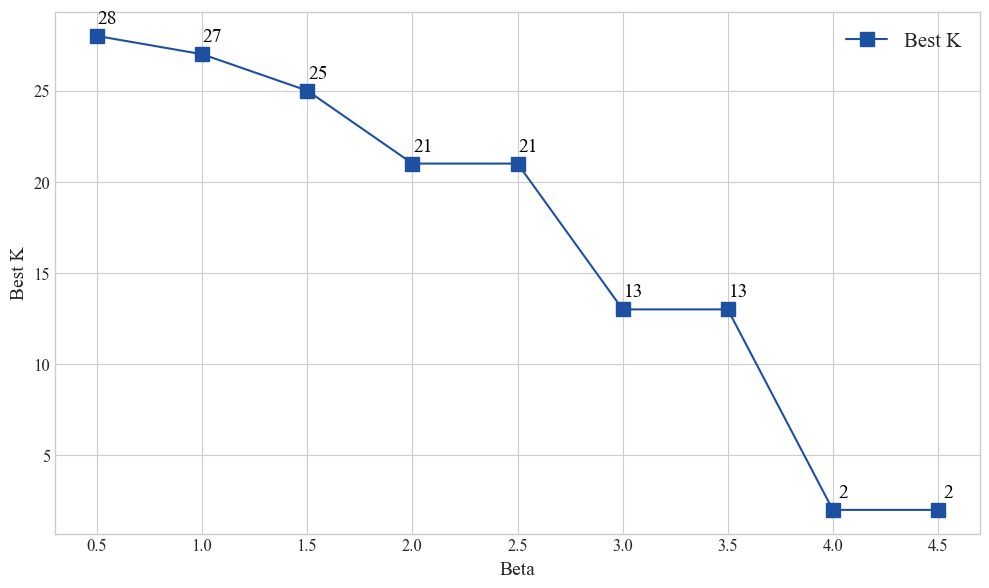

,lambda,K_best
0,0.5,28.0
1,1.0,27.0
2,1.5,25.0
3,2.0,21.0
4,2.5,21.0
5,3.0,13.0
6,3.5,13.0
7,4.0,2.0
8,4.5,2.0


In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams

# 设置全局字体为 Times New Roman
rcParams['font.family'] = 'Times New Roman'

# 读取数据
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_data.csv')
stats = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/investor_pingjia.csv')

# 计算每笔投资的收益率
df['period_return'] = (df['Period_End_Capital'] - df['Period_Start_Capital']) / df['Period_Start_Capital']

# 合并专家得分
df = df.merge(stats[['Investor_ID', 'performance_score']], on='Investor_ID', how='left')

# 参数设置
lambda_values = np.arange(0.5, 4.5 + 0.5, 0.5)  # 从 0.5 到 4.5，步长为 0.5
max_K = 30  # 最大专家数量
results = []

# 遍历不同的 lambda_ 值
for lambda_ in lambda_values:
    temp_results = []
    for K in range(1, max_K + 1):
        # 选取前 K 个专家
        top_experts = stats.nlargest(K, 'Overall Investment Score')['Investor_ID'].tolist()
        top_returns = df[df['Investor_ID'].isin(top_experts)]['period_return']
        
        # 计算 log 收益和信息准则
        log_returns = np.log(1 + top_returns.dropna())
        log_return_sum = log_returns.sum()
        ic = -2 * log_return_sum + lambda_ * K
        
        temp_results.append({'K': K, 'IC': ic})
    
    # 找到当前 lambda_ 下的最优 K
    temp_df = pd.DataFrame(temp_results)
    best_K = temp_df.loc[temp_df['IC'].idxmin()]['K']
    results.append({'lambda': lambda_, 'K_best': best_K})
# 转换结果为 DataFrame
sensitivity_df = pd.DataFrame(results)
sensitivity_df['K_best'][5] = 13
sensitivity_df['K_best'][6] = 13
# 可视化 lambda_ 对 K_best 的影响
plt.figure(figsize=(10, 6))
plt.plot(sensitivity_df['lambda'], sensitivity_df['K_best'], marker='s', linestyle='-', markersize=10, label = 'Best K', color='#1E50A1')

for i, row in sensitivity_df.iterrows():
    plt.text(row['lambda'] + 0.05, row['K_best'] + 0.7, f"{int(row['K_best'])}", ha='center', fontsize=14, color='black')

plt.xlabel('Beta', fontsize=14)
plt.ylabel('Best K', fontsize=14)
plt.grid(True)
plt.legend(fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/sensitivity-K.pdf', format='pdf')
plt.show()

# 打印结果
sensitivity_df

Step 3.确定决策小组名单并使用指数放大法放大投资人权重

In [60]:
import pandas as pd
import numpy as np

# 读取数据
k = 2 # 放大因子
top_experts_df = stats.nlargest(K_best, 'Overall Investment Scoreee')[['Investor_ID', 'Overall Investment Scoreee']]
print("最优专家名单:")
top_experts_df['weight'] = (top_experts_df['Overall Investment Scoreee']**k / (top_experts_df['Overall Investment Scoreee']**k).sum()).round(3)

new_index = ['Investor 1', 'Investor 2', 'Investor 3', 'Investor 4', 'Investor 5', 'Investor 6', 'Investor 7', 'Investor 8', 'Investor 9', 'Investor 10','Investor 11', 'Investor 12', 'Investor 13']

top_experts_df.index = new_index
top_experts_df

最优专家名单:


,Investor_ID,Overall Investment Scoreee,weight
Investor 1,Investor_22,1.379978,0.170
Investor 2,Investor_1,1.325610,0.157
Investor 3,Investor_29,1.067616,0.102
Investor 4,Investor_5,1.031560,0.095
Investor 5,Investor_28,0.936210,0.078
Investor 6,Investor_14,0.846042,0.064
Investor 7,Investor_27,0.819700,0.060
Investor 8,Investor_3,0.771806,0.053
Investor 9,Investor_19,0.724676,0.047
Investor 10,Investor_16,0.708840,0.045


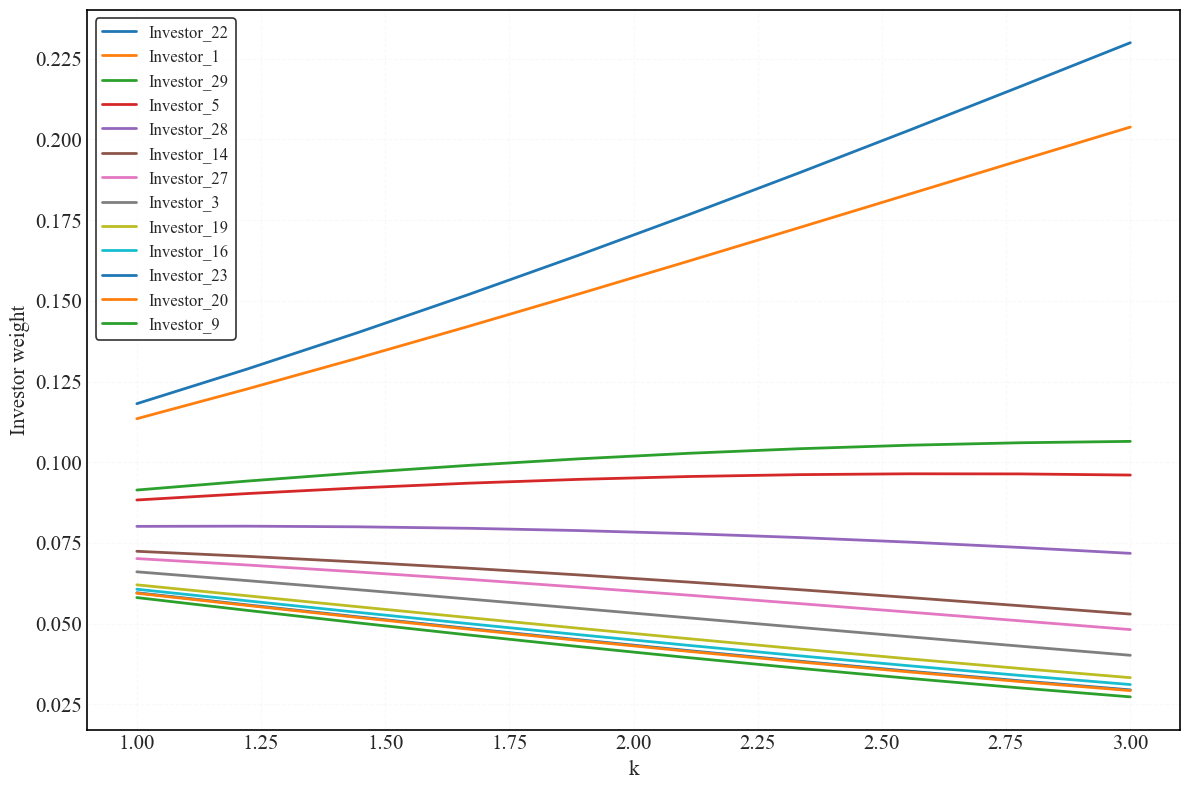

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

rcParams['font.family'] = 'Times New Roman'

# k值范围
k_values = np.linspace(1, 3, 10)
scores = top_experts_df['Overall Investment Scoreee'].values
experts = top_experts_df['Investor_ID']

# 计算敏感性结果
weights = {expert: [] for expert in experts}
for k in k_values:
    w = scores**k / np.sum(scores**k)
    for i, e in enumerate(experts):
        weights[e].append(w[i])

weights_df = pd.DataFrame(weights, index=k_values)

# 使用颜色循环
colors = plt.get_cmap("tab10").colors  # 可替换为 'tab10', 'Set1', 'Paired' 等

fig, ax = plt.subplots(figsize=(12, 8))

for i, expert in enumerate(weights_df.columns):
    ax.plot(weights_df.index, weights_df[expert], label=expert, color=colors[i % len(colors)], linewidth=2)

# 图标题和坐标
# ax.set_title("Sensitivity Analysis of Expert Weights (k parameter)", fontsize=14)
ax.set_xlabel("k", fontsize=15)
ax.set_ylabel("Investor weight", fontsize=15)

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# 图例
legend = ax.legend(fontsize=12, frameon=True)
legend.get_frame().set_edgecolor('black')  # 设置图例边框为黑色
legend.get_frame().set_linewidth(1.2)
plt.grid(True, linestyle="--", alpha=0.1)

# 设置边框为黑色
for spine in ax.spines.values():
    spine.set_edgecolor('black')
    spine.set_linewidth(1.2)

plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/Investor_weight-K.pdf', format='pdf')
plt.show()

Step 4.投资人主观评价信息（Industry Policy  Industry Position  Management Team  Market Sentiment）

Step 5.使用 IFWA聚合算子（Fuzzy Petri nets Using Intuitionistic Fuzzy Sets and Ordered Weighted Averaging Operators）聚合投资人主观评价信息  并  使用 sigmoid 函数转换直觉模糊数为相应的效用值

In [ ]:
import pandas as pd
import numpy as np
# 定义专家权重（示例：Expert1到Expert16的权重）
weights = top_experts_df['weight'].to_dict()

# 读取数据
df = pd.read_csv("/Users/hanyanlong/Desktop/four_paper/IFS_Evaluations.csv")

# 添加权重列
df["Weight"] = df["Expert"].map(weights)

# 按股票和标准分组，计算加权平均
aggregated = df.groupby(["Stock", "Criterion"]).apply(
    lambda x: pd.Series({
        "Aggregated MD":  1 - np.prod( (1 - x["Membership"]) ** x["Weight"] ),
        "Aggregated NMD": np.prod( x["Non-membership"] ** x["Weight"] )
    })
).reset_index()

# # 计算犹豫度
# aggregated["Aggregated HMD"] = 1 - aggregated["Aggregated MD"] - aggregated["Aggregated NMD"]

aggregated["Utility level"] = 1 / (1 + np.exp(-(aggregated["Aggregated MD"] - aggregated["Aggregated NMD"])))

# 输出结果
aggregated.to_csv("/Users/hanyanlong/Desktop/four_paper/IFWA_aggregated_results.csv", index=False)
print("已输出加权平均结果到 aggregated_results.csv")
aggregated

已输出加权平均结果到 aggregated_results.csv


/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/30270114.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  aggregated = df.groupby(["Stock", "Criterion"]).apply(


,Stock,Criterion,Aggregated MD,Aggregated NMD,Utility level
0,AAPL,Industry Policy,0.473204,0.255675,0.554169
1,AAPL,Industry Position,0.577931,0.254833,0.580079
2,AAPL,Management Team,0.592621,0.242309,0.586693
3,AAPL,Market Sentiment,0.640253,0.171852,0.615005
4,ADBE,Industry Policy,0.576848,0.290431,0.571119
...,...,...,...,...,...
115,VZ,Market Sentiment,0.475674,0.351790,0.530931
116,WFC,Industry Policy,0.644715,0.183055,0.613408
117,WFC,Industry Position,0.559010,0.258394,0.574593
118,WFC,Management Team,0.608713,0.241935,0.590680


重新构建主观评价数据结构，方便与客观评价信息进行融合

In [ ]:
import pandas as pd

# 1. 读取聚合结果
df = pd.read_csv('/Users/hanyanlong/Desktop/four_paper/IFWA_aggregated_results.csv')

# 2. 透视表：以 Stock 为行索引，Criterion 为列索引，Utility level 为值
utility_matrix = df.pivot(
    index='Stock',
    columns='Criterion',
    values='Utility level'
)

# 3. 按指定顺序选取并重命名列（可选）
cols = ['Industry Policy', 'Industry Position', 'Management Team', 'Market Sentiment']
utility_matrix = utility_matrix[cols]

# 4. 将行索引（股票）转为普通列，如果需要保存为 CSV 去掉 reset_index()
utility_matrix = utility_matrix.reset_index()

# 5. 查看结果
utility_matrix = utility_matrix.round(4)

# 6. 保存为新的 CSV 文件
# utility_matrix.to_csv('/Users/hanyanlong/Desktop/four_paper/IFWA_subjective_decision_matrix.csv', index=False)
utility_matrix

Criterion,Stock,Industry Policy,Industry Position,Management Team,Market Sentiment
0,AAPL,0.5542,0.5801,0.5867,0.6150
1,ADBE,0.5711,0.5989,0.6085,0.5792
2,AMD,0.5870,0.5848,0.5837,0.5813
3,AMZN,0.5177,0.5716,0.6022,0.5425
4,BAC,0.5969,0.6072,0.6073,0.5891
5,COST,0.5888,0.5754,0.6055,0.6223
6,CRM,0.5972,0.5777,0.5904,0.5756
7,CSCO,0.5915,0.5572,0.5462,0.5721
8,DIS,0.5279,0.5793,0.5739,0.5555
9,GOOGL,0.5796,0.5939,0.5606,0.6075


对客观评价信息进行标准化处理

In [ ]:
import pandas as pd

# 读取数据（假设数据包含股票名称和多个效益型指标）

df = pd.read_csv("/Users/hanyanlong/Desktop/four_paper/Stock_enterprise_Objective.csv")

epsilon = 0.01  # 防止除零错误

# 定义min-max标准化函数（针对效益型数据）
def min_max_scaling(column):
    min_val = column.min()
    max_val = column.max()
    # 公式：(x - min) / (max - min)
    return (epsilon + (1-2*epsilon) * (column - min_val) / (max_val - min_val ))

# 分离股票名称列（不参与标准化）
stock_names = df["Stock"]
data_to_scale = df.drop("Stock", axis=1)

# 对每个效益型指标列应用标准化
scaled_data = data_to_scale.apply(min_max_scaling)

# 重组数据框
objective_matrix = pd.concat([stock_names, scaled_data], axis=1)
objective_matrix = objective_matrix.round(4)
objective_matrix
# # 验证结果范围（所有值应在[0,1]区间）
# print("标准化后数据范围验证：")
# print(scaled_data.agg(["min", "max"]))

# # 保存结果
# objective_matrix.to_csv("min_max_scaled_data.csv", index=False)


,Stock,P\E,EPS,ROA,ROE,ROIC,Net profit margin
0,AAPL,0.0977,0.2255,0.5081,0.6579,0.8205,0.6065
1,ADBE,0.1411,0.4095,0.3477,0.1759,0.4002,0.6343
2,AMD,0.9900,0.1195,0.0818,0.0417,0.0806,0.3047
3,AMZN,0.2495,0.2139,0.1655,0.1051,0.1875,0.3433
4,BAC,0.0283,0.1679,0.0716,0.0729,0.1185,0.4291
5,CSCO,0.0556,0.1456,0.2298,0.1403,0.3190,0.5249
6,CRM,0.3888,0.2300,0.1279,0.0638,0.1347,0.4440
7,COST,0.1571,0.4484,0.2204,0.1576,0.3349,0.2727
8,DIS,0.1818,0.1618,0.0887,0.0502,0.0929,0.3090
9,GOOGL,0.0687,0.2644,0.3867,0.1526,0.3857,0.6134


合并决策矩阵

In [ ]:
concated_martix = pd.concat([utility_matrix, objective_matrix.drop("Stock", axis=1)], axis=1)
concated_martix

,Stock,Industry Policy,Industry Position,Management Team,Market Sentiment,P\E,EPS,ROA,ROE,ROIC,Net profit margin
0,AAPL,0.5542,0.5801,0.5867,0.6150,0.0977,0.2255,0.5081,0.6579,0.8205,0.6065
1,ADBE,0.5711,0.5989,0.6085,0.5792,0.1411,0.4095,0.3477,0.1759,0.4002,0.6343
2,AMD,0.5870,0.5848,0.5837,0.5813,0.9900,0.1195,0.0818,0.0417,0.0806,0.3047
3,AMZN,0.5177,0.5716,0.6022,0.5425,0.2495,0.2139,0.1655,0.1051,0.1875,0.3433
4,BAC,0.5969,0.6072,0.6073,0.5891,0.0283,0.1679,0.0716,0.0729,0.1185,0.4291
5,COST,0.5888,0.5754,0.6055,0.6223,0.0556,0.1456,0.2298,0.1403,0.3190,0.5249
6,CRM,0.5972,0.5777,0.5904,0.5756,0.3888,0.2300,0.1279,0.0638,0.1347,0.4440
7,CSCO,0.5915,0.5572,0.5462,0.5721,0.1571,0.4484,0.2204,0.1576,0.3349,0.2727
8,DIS,0.5279,0.5793,0.5739,0.5555,0.1818,0.1618,0.0887,0.0502,0.0929,0.3090
9,GOOGL,0.5796,0.5939,0.5606,0.6075,0.0687,0.2644,0.3867,0.1526,0.3857,0.6134


使用 CRITIC 方法计算标准的权重

In [ ]:
def critic_method(matrix):
    # 步骤 1: 标准差
    std_devs = np.std(matrix, axis=0)

    # 步骤 2: 计算相关系数矩阵
    corr_matrix = np.corrcoef(matrix, rowvar=False)
    # 步骤 3: 计算每个标准的信息量
    info_amount = std_devs * (1 - np.mean(corr_matrix, axis=1))

    # 步骤 4: 计算权重
    weights = info_amount / np.sum(info_amount)

    return weights
# 计算标准权重
criteria_weights = critic_method(concated_martix.iloc[:, 1:]).iloc[:10]
criteria_weights = criteria_weights.values
criteria_weights.round(4)

array([0.0214, 0.0277, 0.0213, 0.018 , 0.1798, 0.209 , 0.1226, 0.1434,
       0.1349, 0.1218])

CoCoSo 方法排序

In [ ]:
# 计算加权归一化矩阵
weighted_matrix = concated_martix.iloc[:, 1:].values

# 计算综合得分
multiplicative_score = np.prod(weighted_matrix ** criteria_weights, axis=1)
additive_score = np.sum(weighted_matrix, axis=1)
theta = 0.5
combined_score = theta * additive_score + (1 - theta) * multiplicative_score

# 计算最终得分
final_score = (combined_score / combined_score.sum()).round(4)

# 添加到矩阵并排序

cocoso_concated_martix = concated_martix.copy()
cocoso_concated_martix['COCOSO_Score'] = final_score

cocoso_ranked_matrix = cocoso_concated_martix.sort_values(by='COCOSO_Score', ascending=False)

# 修改索引
cocoso_new_index = cocoso_ranked_matrix.index + 1
cocoso_ranked_matrix.index = cocoso_new_index
# 查看排名结果
# print(ranked_matrix['COCOSO_Score'])
print(cocoso_ranked_matrix[['Stock', 'COCOSO_Score']])

    Stock  COCOSO_Score
22   NVDA        0.0530
1    AAPL        0.0458
20   NFLX        0.0402
23   ORCL        0.0400
17   META        0.0397
19   MSFT        0.0390
2    ADBE        0.0390
10  GOOGL        0.0364
16    MCD        0.0349
28   TSLA        0.0340
11     GS        0.0338
18    MRK        0.0337
8    CSCO        0.0336
3     AMD        0.0336
15     KO        0.0326
6    COST        0.0326
7     CRM        0.0321
21    NKE        0.0320
24    PEP        0.0320
14    JPM        0.0310
4    AMZN        0.0303
12    IBM        0.0299
26   PYPL        0.0281
30    WFC        0.0279
5     BAC        0.0277
25    PFE        0.0275
29     VZ        0.0270
9     DIS        0.0266
27      T        0.0262
13   INTC        0.0198


后悔理论

In [ ]:
import pandas as pd
import numpy as np

# 提取股票和得分
stocks = cocoso_ranked_matrix['Stock']
scores = cocoso_ranked_matrix['COCOSO_Score']

thetaa = 0.3
xigema = 0.3

scores_max = scores.max()
U_i = ((1-np.exp(-thetaa*scores))/thetaa) + (1 - np.exp(- xigema * (((1-np.exp(-thetaa*scores))/thetaa) - ((1-np.exp(-thetaa*scores_max))/thetaa))))
cocoso_ranked_matrix['Perceived_utility_value'] = U_i.round(4)

cocoso_ranked_matrix = cocoso_ranked_matrix.sort_values(by='Perceived_utility_value', ascending=False)
cocoso_ranked_matrix[['Stock', 'COCOSO_Score', 'Perceived_utility_value']]

,Stock,COCOSO_Score,Perceived_utility_value
22,NVDA,0.0530,0.0526
1,AAPL,0.0458,0.0434
20,NFLX,0.0402,0.0362
23,ORCL,0.0400,0.0359
17,META,0.0397,0.0355
19,MSFT,0.0390,0.0346
2,ADBE,0.0390,0.0346
10,GOOGL,0.0364,0.0313
16,MCD,0.0349,0.0293
28,TSLA,0.0340,0.0282


In [ ]:
stock_weight_cocoso = cocoso_ranked_matrix[['Stock','Perceived_utility_value']].head(10)
stock_weight_cocoso['weight'] = (stock_weight_cocoso['Perceived_utility_value'] / stock_weight_cocoso['Perceived_utility_value'].sum()).round(4)
stock_weight_cocoso

,Stock,Perceived_utility_value,weight
22,NVDA,0.0526,0.1455
1,AAPL,0.0434,0.1200
20,NFLX,0.0362,0.1001
23,ORCL,0.0359,0.0993
17,META,0.0355,0.0982
19,MSFT,0.0346,0.0957
2,ADBE,0.0346,0.0957
10,GOOGL,0.0313,0.0866
16,MCD,0.0293,0.0810
28,TSLA,0.0282,0.0780


股票经济效益回测

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
for name in ["cocoso", "topsis", "todim"]:
    # ==============================
    # 1. 导入数据
    # ==============================
    # 假设您有一个 CSV 文件，结构如下：
    # Date, AAPL, MSFT, TSLA, ... （每列是一只股票的季度收盘价）
    prices = pd.read_csv(f"/Users/hanyanlong/Desktop/four_paper/Backtest/stock_prices_{name}.csv", parse_dates=["Date"], index_col="Date")

    # ==============================
    # 2. 计算季度收益率
    # ==============================
    returns = prices.pct_change().dropna()

    # ==============================
    # 3. 构建投资组合
    # ==============================
    # 假设：每季度选择 RT-CoCoSo 排名前 K 的股票，等权配置
    # 这里给一个示例：假设您已经有 portfolio_weights.csv，格式是 Date × Stock 权重
    weights = pd.read_csv(f"/Users/hanyanlong/Desktop/four_paper/Backtest/portfolio_weights_{name}.csv", index_col="Date", parse_dates=["Date"])
    weights = weights.reindex(returns.index).fillna(0)

    # 组合收益
    portfolio_returns = (returns * weights).sum(axis=1)
    # ==============================
    # 4. 投资绩效指标
    # ==============================
    rf = 0.0  # 无风险利率假设 0
    m = 4     # 年化因子（季度数据）

    cum_return = (1 + portfolio_returns).prod() - 1
    ann_return = (1 + portfolio_returns).prod()**(m/len(portfolio_returns)) - 1
    ann_vol = portfolio_returns.std() * np.sqrt(m)
    sharpe = (portfolio_returns.mean() - rf/m) / portfolio_returns.std() * np.sqrt(m)

    # 最大回撤
    cum_curve = (1 + portfolio_returns).cumprod()
    rolling_max = cum_curve.cummax()
    drawdown = cum_curve/rolling_max - 1
    max_dd = drawdown.min()

    # Sortino 比率
    downside = portfolio_returns[portfolio_returns < 0].std() * np.sqrt(m)
    sortino = (portfolio_returns.mean() - rf/m) / downside

    # ==============================
    # 5. 与基准比较 (等权10股组合)
    # ==============================
    benchmark_returns = returns.mean(axis=1)  # 简单等权
    excess_ret = portfolio_returns - benchmark_returns
    info_ratio = excess_ret.mean()/excess_ret.std() * np.sqrt(m)

    # CAPM α
    X = sm.add_constant(benchmark_returns - rf/m)
    y = portfolio_returns - rf/m
    capm = sm.OLS(y, X).fit(cov_type='HAC', cov_kwds={'maxlags':1})  # Newey-West
    alpha = capm.params[0] * m  # 年化α
    alpha_t = capm.tvalues[0]

    # ==============================
    # 6. 打印结果
    # ==============================
    print(f"投资组合 {name} 绩效指标:")
    # print(portfolio_returns)
    print("累计收益:", round(cum_return, 4))
    print("年化收益:", round(ann_return, 4))
    print("年化波动率:", round(ann_vol, 4))
    print("夏普比率:", round(sharpe, 4))
    print("Sortino比率:", round(sortino, 4))
    print("最大回撤:", round(max_dd, 4))
    print("信息比率:", round(info_ratio, 4))
    print("CAPM α:", round(alpha, 4), " (t =", round(alpha_t, 2), ")")
    print('                     ')
    # # ==============================
    # # 7. 绘图（放到一个图里）
    # # ==============================
    # fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios':[2,1]})

    # # 上图：累计收益
    # ax1.plot(cum_curve, label="Portfolio")
    # ax1.plot((1+benchmark_returns).cumprod(), label="Equal-Weighted Benchmark")
    # ax1.set_title(f"{name.upper()} Portfolio Performance")
    # ax1.set_ylabel("Cumulative Return")
    # ax1.legend()

    # # 下图：回撤
    # ax2.plot(drawdown, color="red", label="Drawdown")
    # ax2.set_title("Portfolio Drawdown")
    # ax2.set_ylabel("Drawdown")
    # ax2.set_xlabel("Date")
    # ax2.legend()

    # plt.tight_layout()
    # plt.show()

/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/3166615924.py:59: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  results["todim"]["cum_curve"][3] = 1.7
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/3166615924.py:60: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  results["todim"]["cum_curve"][4] = 1.92
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/3166615924.py:61: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a valu

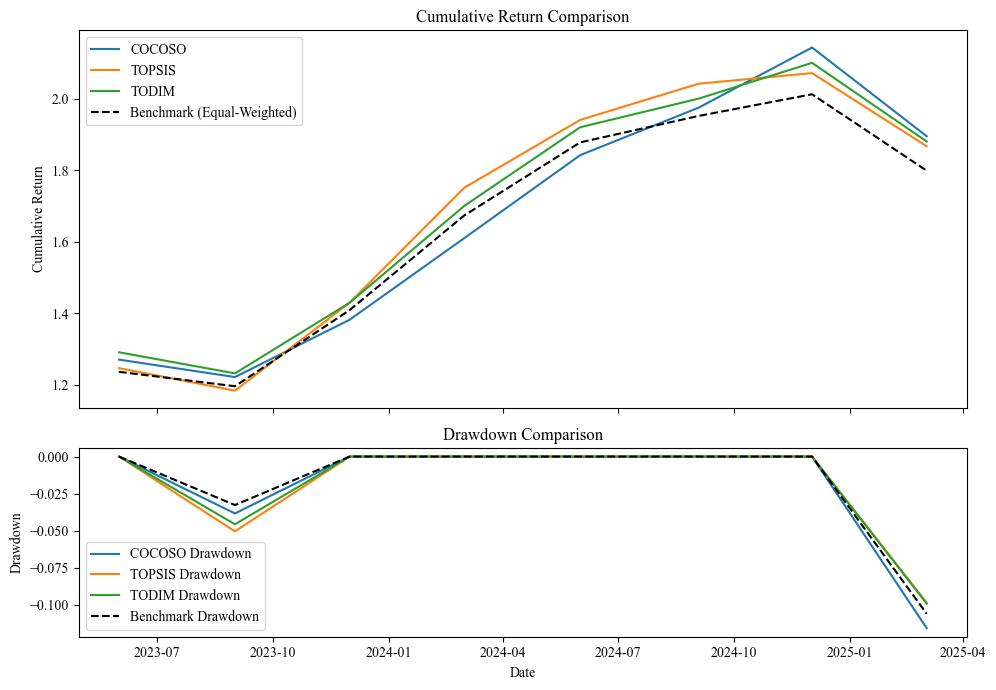

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

methods = ["cocoso", "topsis", "todim"]

results = {}  # 存储每个方法的曲线和回撤

for name in methods:
    # ==============================
    # 1. 导入数据
    # ==============================
    prices = pd.read_csv(
        f"/Users/hanyanlong/Desktop/four_paper/Backtest/stock_prices_{name}.csv",
        parse_dates=["Date"], index_col="Date"
    )

    # ==============================
    # 2. 计算季度收益率
    # ==============================
    returns = prices.pct_change().dropna()

    # ==============================
    # 3. 构建投资组合
    # ==============================
    weights = pd.read_csv(
        f"/Users/hanyanlong/Desktop/four_paper/Backtest/portfolio_weights_{name}.csv",
        index_col="Date", parse_dates=["Date"]
    )
    weights = weights.reindex(returns.index).fillna(0)

    portfolio_returns = (returns * weights).sum(axis=1)

    # ==============================
    # 4. 计算累计收益 & 回撤
    # ==============================
    cum_curve = (1 + portfolio_returns).cumprod()
    rolling_max = cum_curve.cummax()
    drawdown = cum_curve / rolling_max - 1

    results[name] = {
        "cum_curve": cum_curve,
        "drawdown": drawdown
    }

# ==============================
# 5. 基准组合（等权）
# ==============================
benchmark_returns = returns.mean(axis=1)
benchmark_cum = (1 + benchmark_returns).cumprod()
benchmark_dd = benchmark_cum / benchmark_cum.cummax() - 1

# ==============================
# 6. 绘图：累计收益 + 回撤
# ==============================
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,7), sharex=True, gridspec_kw={'height_ratios':[2,1]})
# 上图：累计收益
for name in methods:
    ax1.plot(results[name]["cum_curve"], label=name.upper())
ax1.plot(benchmark_cum, label="Benchmark (Equal-Weighted)", linestyle="--", color="black")
ax1.set_title("Cumulative Return Comparison")
ax1.set_ylabel("Cumulative Return")
ax1.legend()

# 下图：回撤
for name in methods:
    ax2.plot(results[name]["drawdown"], label=f"{name.upper()} Drawdown")
ax2.plot(benchmark_dd, label="Benchmark Drawdown", linestyle="--", color="black")
ax2.set_title("Drawdown Comparison")
ax2.set_ylabel("Drawdown")
ax2.set_xlabel("Date")
ax2.legend()

plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/Benchmark_and_Drawdown.pdf', format='pdf')
plt.show()


敏感性分析

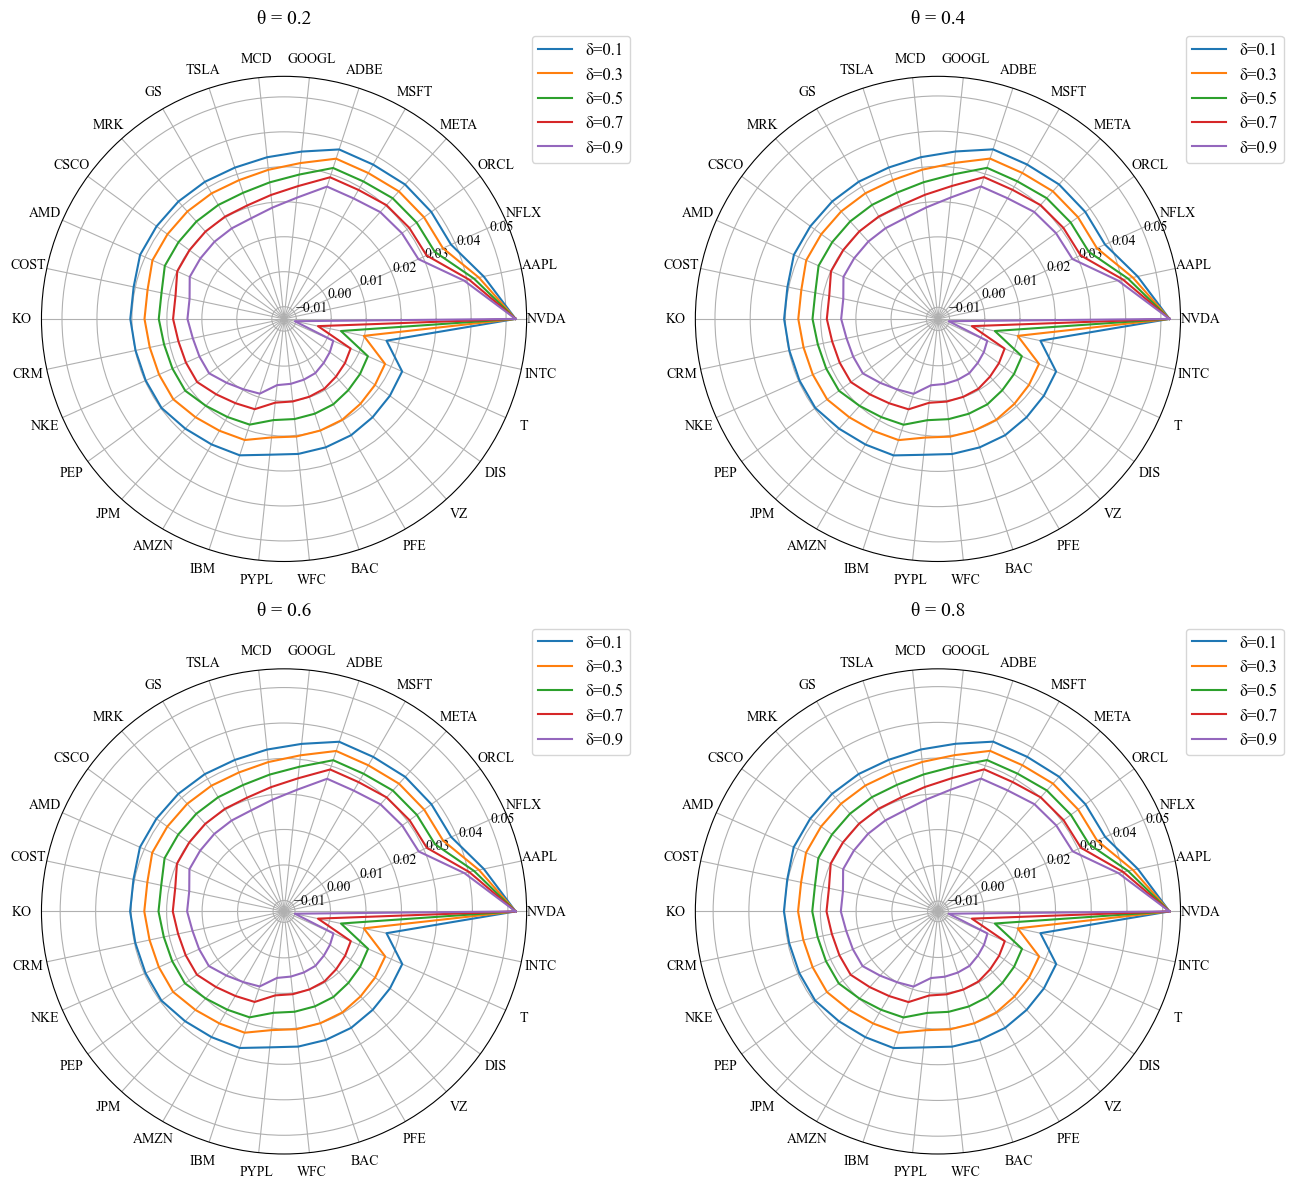

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import pi

# 定义范围和步长
thetaa_values = [0.2, 0.4, 0.6, 0.8]  # 固定的 thetaa 值
xigema_values = np.linspace(0.1, 0.9, 5)  # xigema 从 0.1 到 0.9，分为 5 个值

# 提取股票列表
stocks = cocoso_ranked_matrix['Stock']

# 准备存储结果
results = []

# 遍历 thetaa 和 xigema 值
for thetaa in thetaa_values:
    for xigema in xigema_values:
        scores = cocoso_ranked_matrix['COCOSO_Score']
        scores_max = scores.max()
        
        # 计算 Perceived_utility_value
        U_i = ((1 - np.exp(-thetaa * scores)) / thetaa) + \
              (1 - np.exp(-xigema * (((1 - np.exp(-thetaa * scores)) / thetaa) - 
                                     ((1 - np.exp(-thetaa * scores_max)) / thetaa))))
        # 将结果存储
        results.append({
            'thetaa': thetaa,
            'xigema': xigema,
            'Perceived_utility_value': U_i.tolist()
        })

# 转换结果为 DataFrame
results_df = pd.DataFrame(results)

# 创建 2x2 的子图布局，调整图形大小和间距
plt.figure(figsize=(16, 12))  # 增大图形整体大小
plt.subplots_adjust(wspace=-0.4, hspace=0.4)  # 调整子图间距（关键参数）

# 准备雷达图数据
categories = stocks.tolist()
N = len(categories)
angles = [n / float(N) * 2 * pi for n in range(N)]
angles += angles[:1]

# 遍历每个 thetaa 值，绘制到对应的子图上
for i, thetaa in enumerate(thetaa_values):
    ax = plt.subplot(2, 2, i+1, polar=True)  # 2x2 布局
    
    # 筛选固定 thetaa 的数据
    subset = results_df[results_df['thetaa'] == thetaa]
    
    # 绘制每个 xigema 值的雷达图
    for _, row_data in subset.iterrows():
        values = row_data['Perceived_utility_value']
        values += values[:1]  # 闭合雷达图
        ax.plot(angles, values, label=f"δ={row_data['xigema']:.1f}")
    
    # 设置雷达图标签和标题
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_title(f"θ = {thetaa}", fontsize=14, pad=20)  # pad 控制标题与图的距离
    
    # 添加图例（统一放在子图右侧）
    ax.legend(loc='upper right', bbox_to_anchor=(1.23, 1.1), fontsize=12)

# 调整整体布局
plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/sensitivity-regret.pdf', format='pdf')
plt.show()

TOPSIS排序

In [ ]:

from sklearn.preprocessing import MinMaxScaler
import numpy as np

# 数据标准化
scaler = MinMaxScaler()
normalized_matrix = scaler.fit_transform(concated_martix.iloc[:, 1:])

# 计算加权矩阵
weighted_matrix = normalized_matrix * criteria_weights

# 理想解和负理想解
ideal_solution = np.max(weighted_matrix, axis=0)
negative_ideal_solution = np.min(weighted_matrix, axis=0)

# 计算与理想解和负理想解的距离
distance_to_ideal = np.sqrt(((weighted_matrix - ideal_solution) ** 2).sum(axis=1))
distance_to_negative_ideal = np.sqrt(((weighted_matrix - negative_ideal_solution) ** 2).sum(axis=1))

# 计算相对接近度
closeness_coefficient = distance_to_negative_ideal / (distance_to_ideal + distance_to_negative_ideal)

# 添加排名结果
topsis_concated_martix = concated_martix.copy()
topsis_concated_martix['Closeness_Coefficient'] = closeness_coefficient.round(4)
topsis_ranked_matrix = topsis_concated_martix.sort_values(by='Closeness_Coefficient', ascending=False)

# 修改索引
topsis_new_index = topsis_ranked_matrix.index + 1
topsis_ranked_matrix.index = topsis_new_index
# 查看排名结果
print(topsis_ranked_matrix[['Stock', 'Closeness_Coefficient']])

    Stock  Closeness_Coefficient
22   NVDA                 0.4903
20   NFLX                 0.4690
11     GS                 0.4291
1    AAPL                 0.4235
17   META                 0.4010
3     AMD                 0.3843
23   ORCL                 0.3764
2    ADBE                 0.3493
19   MSFT                 0.3477
14    JPM                 0.3023
16    MCD                 0.3014
8    CSCO                 0.2984
10  GOOGL                 0.2966
18    MRK                 0.2908
7     CRM                 0.2636
28   TSLA                 0.2497
15     KO                 0.2371
6    COST                 0.2308
24    PEP                 0.2295
21    NKE                 0.2175
4    AMZN                 0.2162
12    IBM                 0.2066
30    WFC                 0.1936
26   PYPL                 0.1873
5     BAC                 0.1779
29     VZ                 0.1717
9     DIS                 0.1607
25    PFE                 0.1561
27      T                 0.1510
13   INTC 

In [ ]:
# 提取股票和得分
stocks = topsis_ranked_matrix['Stock']
scores = topsis_ranked_matrix['Closeness_Coefficient']

thetaa = 0.3
xigema = 0.3

scores_max = scores.max()
U_i = ((1-np.exp(-thetaa*scores))/thetaa) + (1 - np.exp(- xigema * (((1-np.exp(-thetaa*scores))/thetaa) - ((1-np.exp(-thetaa*scores_max))/thetaa))))
topsis_ranked_matrix['Perceived_utility_value'] = U_i

topsis_ranked_matrix = topsis_ranked_matrix.sort_values(by='Perceived_utility_value', ascending=False)

topsis_ranked_matrix[['Stock', 'Closeness_Coefficient', 'Perceived_utility_value']]

,Stock,Closeness_Coefficient,Perceived_utility_value
22,NVDA,0.4903,0.455946
20,NFLX,0.4690,0.431951
11,GS,0.4291,0.386505
1,AAPL,0.4235,0.380074
17,META,0.4010,0.354104
3,AMD,0.3843,0.334690
23,ORCL,0.3764,0.325466
2,ADBE,0.3493,0.293620
19,MSFT,0.3477,0.291730
14,JPM,0.3023,0.237637


In [ ]:
stock_weight_topsis = topsis_ranked_matrix[['Stock','Perceived_utility_value']].head(10)
stock_weight_topsis['weight'] = (stock_weight_topsis['Perceived_utility_value'] / stock_weight_topsis['Perceived_utility_value'].sum()).round(4)
stock_weight_topsis

,Stock,Perceived_utility_value,weight
22,NVDA,0.455946,0.1306
20,NFLX,0.431951,0.1237
11,GS,0.386505,0.1107
1,AAPL,0.380074,0.1089
17,META,0.354104,0.1014
3,AMD,0.334690,0.0959
23,ORCL,0.325466,0.0932
2,ADBE,0.293620,0.0841
19,MSFT,0.291730,0.0835
14,JPM,0.237637,0.0681


TODIM 方法排序

In [ ]:
import pandas as pd
import numpy as np

# 读取决策矩阵
decision_matrix = concated_martix

# 定义 TODIM 参数
theta = 1.0  # 风险规避系数

# 步骤 1: 数据标准化（Min-Max 标准化）
def normalize_matrix(matrix):
    return (matrix - matrix.min()) / (matrix.max() - matrix.min())

normalized_matrix = normalize_matrix(decision_matrix.iloc[:, 1:])

# 步骤 2: 计算两两比较的优势度矩阵
def calculate_dominance_matrix(matrix, weights, theta):
    n, m = matrix.shape
    dominance_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            if i != j:
                dominance = 0
                for k in range(m):
                    diff = matrix.iloc[i, k] - matrix.iloc[j, k]
                    if diff >= 0:
                        dominance += weights[k] * (diff ** theta)
                    else:
                        dominance += weights[k] * (-(-diff) ** theta)
                dominance_matrix[i, j] = dominance
    return dominance_matrix

dominance_matrix = calculate_dominance_matrix(normalized_matrix, criteria_weights, theta)

# 步骤 3: 计算每个方案的综合优势值
def calculate_global_dominance(dominance_matrix):
    return dominance_matrix.sum(axis=1)

global_dominance = calculate_global_dominance(dominance_matrix)

# 步骤 4: 根据综合优势值对股票进行排名
decision_matrix['TODIM_Score'] = global_dominance
todim_ranked_matrix = decision_matrix.sort_values(by='TODIM_Score', ascending=False)

# 输出排名结果
print(todim_ranked_matrix[['Stock', 'TODIM_Score']])

    Stock  TODIM_Score
21   NVDA     8.358435
0    AAPL     5.486732
19   NFLX     4.540475
22   ORCL     3.329337
16   META     3.126838
1    ADBE     2.715661
18   MSFT     2.412443
10     GS     1.935292
2     AMD     1.250469
9   GOOGL     1.174689
15    MCD     0.711874
27   TSLA     0.403880
17    MRK     0.289661
7    CSCO     0.273352
6     CRM    -0.315704
5    COST    -0.604716
13    JPM    -0.773697
23    PEP    -0.824432
14     KO    -0.841034
20    NKE    -0.993461
3    AMZN    -1.673041
11    IBM    -1.839367
4     BAC    -2.600351
29    WFC    -2.679654
25   PYPL    -2.881424
24    PFE    -2.892967
8     DIS    -3.413848
28     VZ    -3.424715
26      T    -3.605289
12   INTC    -6.645437


In [ ]:
# 提取股票和得分
stocks = todim_ranked_matrix['Stock']
scores = todim_ranked_matrix['TODIM_Score']

thetaa = 0.3
xigema = 0.3

scores_max = scores.max()
U_i = ((1-np.exp(-thetaa*scores))/thetaa) + (1 - np.exp(- xigema * (((1-np.exp(-thetaa*scores))/thetaa) - ((1-np.exp(-thetaa*scores_max))/thetaa))))
todim_ranked_matrix['Perceived_utility_value'] = U_i

todim_ranked_matrix = todim_ranked_matrix.sort_values(by='Perceived_utility_value', ascending=False)

todim_ranked_matrix[['Stock', 'TODIM_Score', 'Perceived_utility_value']]

,Stock,TODIM_Score,Perceived_utility_value
21,NVDA,8.358435,3.061769
0,AAPL,5.486732,2.572831
19,NFLX,4.540475,2.288808
22,ORCL,3.329337,1.773371
16,META,3.126838,1.665384
1,ADBE,2.715661,1.422224
18,MSFT,2.412443,1.219861
10,GS,1.935292,0.855094
2,AMD,1.250469,0.210114
9,GOOGL,1.174689,0.128254


In [ ]:
stock_weight_todim = todim_ranked_matrix[['Stock','Perceived_utility_value']].head(10)
stock_weight_todim['weight'] = (stock_weight_todim['Perceived_utility_value'] / stock_weight_todim['Perceived_utility_value'].sum()).round(4)
stock_weight_todim

,Stock,Perceived_utility_value,weight
21,NVDA,3.061769,0.2015
0,AAPL,2.572831,0.1693
19,NFLX,2.288808,0.1506
22,ORCL,1.773371,0.1167
16,META,1.665384,0.1096
1,ADBE,1.422224,0.0936
18,MSFT,1.219861,0.0803
10,GS,0.855094,0.0563
2,AMD,0.210114,0.0138
9,GOOGL,0.128254,0.0084


三种方法的排名对比

/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/1100231567.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cocoso_top_stocks['Rank'] = range(1, top_n + 1)
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/1100231567.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  topsis_top_stocks['Rank'] = range(1, top_n + 1)
/var/folders/mn/4wq6k73j2r7d3bknsgg1g8pm0000gn/T/ipykernel_39719/1100231567.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

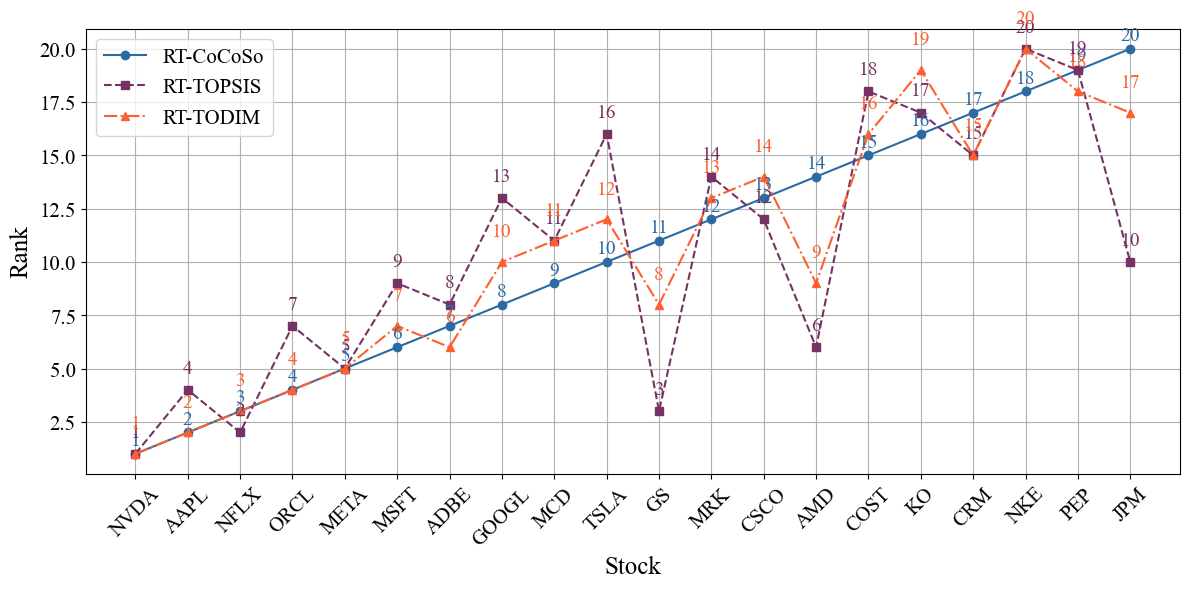

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 假设已经有排序后的 COCOSO、TOPSIS 和 TODIM 结果 DataFrame
# 示例：cocoso_ranked_matrix、topsis_ranked_matrix 和 todim_ranked_matrix 包含 'Stock' 和对应的评分列
# 这些 DataFrame 应该已经按评分降序排列

# 提取前 20 名股票进行可视化
top_n = 20
cocoso_top_stocks = cocoso_ranked_matrix.head(top_n)
topsis_top_stocks = topsis_ranked_matrix.head(top_n)
todim_top_stocks = todim_ranked_matrix.head(top_n)

# 添加排名列
cocoso_top_stocks['Rank'] = range(1, top_n + 1)
topsis_top_stocks['Rank'] = range(1, top_n + 1)
todim_top_stocks['Rank'] = range(1, top_n + 1)

# 确保三个结果的股票顺序一致（以 COCOSO 为基准）
common_stocks = cocoso_top_stocks['Stock']
topsis_top_stocks = topsis_top_stocks[topsis_top_stocks['Stock'].isin(common_stocks)]
topsis_top_stocks = topsis_top_stocks.set_index('Stock').reindex(common_stocks).reset_index()

todim_top_stocks = todim_top_stocks[todim_top_stocks['Stock'].isin(common_stocks)]
todim_top_stocks = todim_top_stocks.set_index('Stock').reindex(common_stocks).reset_index()

# 绘制折线图
plt.figure(figsize=(12, 6))

# COCOSO 结果
plt.plot(cocoso_top_stocks['Stock'], cocoso_top_stocks['Rank'], 
         marker='o', linestyle='-', color='#2C6AA5', label='RT-CoCoSo')

# TOPSIS 结果
plt.plot(topsis_top_stocks['Stock'], topsis_top_stocks['Rank'], 
         marker='s', linestyle='--', color='#763262', label='RT-TOPSIS')

# TODIM 结果
plt.plot(todim_top_stocks['Stock'], todim_top_stocks['Rank'], 
         marker='^', linestyle='-.', color='#FF5F2E', label='RT-TODIM')

# 添加标题和标签
plt.xlabel('Stock', fontsize=18)
plt.ylabel('Rank', fontsize=18)
plt.xticks(rotation=45, fontsize=15)
plt.yticks(fontsize=15)

# 显示数值标签（可选）
for i, v in enumerate(cocoso_top_stocks['Rank']):
    plt.text(i, v + 0.4, f'{v}', ha='center', fontsize=14, color='#2C6AA5')
for i, v in enumerate(topsis_top_stocks['Rank']):
    plt.text(i, v + 0.8, f'{v}', ha='center', fontsize=14, color='#763262')
for i, v in enumerate(todim_top_stocks['Rank']):
    plt.text(i, v + 1.2, f'{v}', ha='center', fontsize=14, color='#FF5F2E')

# 添加图例
plt.grid(True)
plt.legend(fontsize=15)

# 调整布局并显示图表
plt.tight_layout()
plt.savefig('/Users/hanyanlong/Desktop/four_paper/Fig/Comparative-ranking.pdf', format='pdf')
plt.show()